## Name: Suvaditya Mukherjee
## Email: suvadityamuk@gmail.com
## GitHub: [Suvaditya Mukherjee](https://www.github.com/suvadityamuk)

# Introduction & Data Retrieval

## Bash commands for downloading and unzipping dataset. 

- Requires `kaggle.json` if using on Google Colaboratory

In [1]:
!pip install kaggle --no-deps -q
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d saurabhshahane/barkvn50
!unzip barkvn50.zip
!mv BarkVN-50/BarkVN-50_mendeley/* BarkVN-50/
!rm -r BarkVN-50/BarkVN-50_mendeley/
!rm barkvn50.zip

Streaming output truncated to the last 5000 lines.
  inflating: BarkVN-50/BarkVN-50_mendeley/Annona squamosa/IMG_1340.JPG  
  inflating: BarkVN-50/BarkVN-50_mendeley/Annona squamosa/IMG_1341.JPG  
  inflating: BarkVN-50/BarkVN-50_mendeley/Annona squamosa/IMG_1342.JPG  
  inflating: BarkVN-50/BarkVN-50_mendeley/Annona squamosa/IMG_1343.JPG  
  inflating: BarkVN-50/BarkVN-50_mendeley/Annona squamosa/IMG_1344.JPG  
  inflating: BarkVN-50/BarkVN-50_mendeley/Annona squamosa/IMG_1345.JPG  
  inflating: BarkVN-50/BarkVN-50_mendeley/Annona squamosa/IMG_1347.JPG  
  inflating: BarkVN-50/BarkVN-50_mendeley/Annona squamosa/IMG_2914.JPG  
  inflating: BarkVN-50/BarkVN-50_mendeley/Annona squamosa/IMG_2915.JPG  
  inflating: BarkVN-50/BarkVN-50_mendeley/Annona squamosa/IMG_2916.JPG  
  inflating: BarkVN-50/BarkVN-50_mendeley/Annona squamosa/IMG_2917.JPG  
  inflating: BarkVN-50/BarkVN-50_mendeley/Annona squamosa/IMG_2918.JPG  
  inflating: BarkVN-50/BarkVN-50_mendeley/Annona squamosa/IMG_2919.JPG  


## Import headers

- TensorFlow & Keras for modelling
- Matplotlib for plotting graphs and images
- PIL for Image manipulation
- `google.colab` for getting direct Drive access to store/load models
- `warnings` for suppressing old warnings


In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/gdrive


## Setting global parameters for further use

In [3]:
plt.rcParams["figure.figsize"] = (20,10)

RANDOM_SEED = 45
BATCH_SIZE = 32
print('Chosen Batch size : ', BATCH_SIZE)

Chosen Batch size :  32


## Helper functions to save and load pre-trained models

- `saveModel` to allow for simple model saving. 

In [4]:
def saveModel(model:keras.Model, name:str):
    FILE_NAME = f"/content/gdrive/My Drive/TMLC_Models/{name}_latest.h5"
    model.save(FILE_NAME)

In [5]:
def loadModel(model_name:str):
    FILE_NAME = f"/content/gdrive/My Drive/TMLC_Models/{model_name}_latest.h5"
    model = keras.models.load_model(FILE_NAME)
    return model

## Initializing dataset from directory

- Uses `tf.keras.utils.image_dataset_from_directory` to perform image dataset initialization into a `tf.data.Dataset`
- Performs batch-sizing, train-validation split of 90%-10%, image resizing to (224, 224, 3) and label initialization into an integer representation for use with `SparseCategoricalCrossentropy`

In [6]:
train_data = keras.utils.image_dataset_from_directory(
    'BarkVN-50',
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=0.1,
    subset='training'
)
valid_data = keras.utils.image_dataset_from_directory(
    'BarkVN-50',
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED,
    validation_split=0.1,
    subset='validation'
)
classes = train_data.class_names

Found 5578 files belonging to 50 classes.
Using 5021 files for training.
Found 5578 files belonging to 50 classes.
Using 557 files for validation.


## Formatting image datasets by rescaling and resizing individual images while pre-fetching and caching the dataset

- Performs tensor casting into `tf.float32`
- Performs pixel-value scaling from [0,255] to [0,1]
- Enables pre-fetch for the `tf.data.Dataset`
- Enables caching of `tf.data.Dataset`

In [7]:
def format_image(image, label):

    image = tf.cast(image, tf.float32)
    image = tf.keras.layers.Rescaling(scale=1./255)(image)
    return image, label

def prepare_ds(ds):
    
    ds = ds.map(format_image)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    ds = ds.cache()
    return ds

train_ds = prepare_ds(train_data)
valid_ds = prepare_ds(valid_data)

## Visualizing random samples to understand how the images look like

- Display any random number of samples using the function below. For an example of an odd case, we take 7 samples of images and their labels

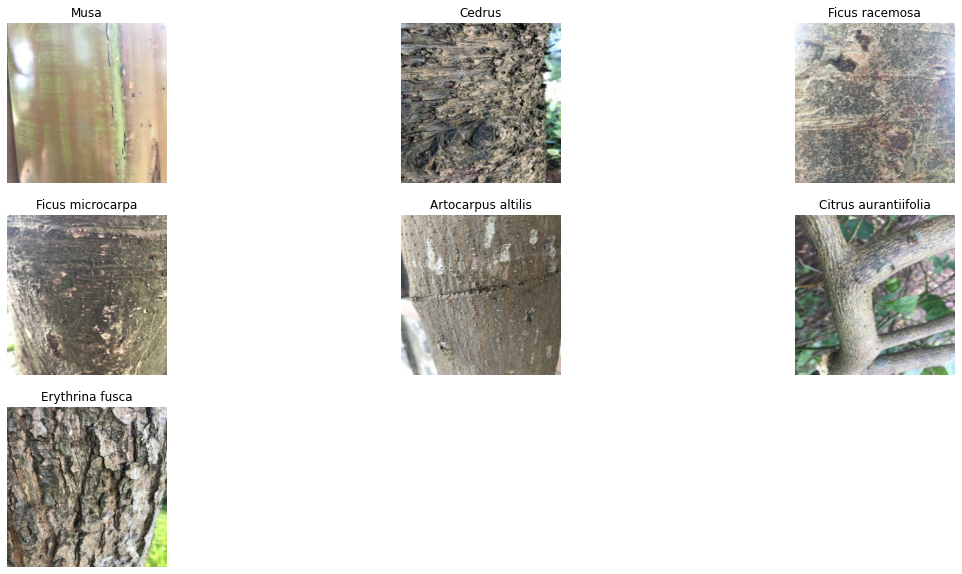

In [8]:
def visualizeRandomSamples(data:tf.data.Dataset, batch_size:int=BATCH_SIZE):

    total_plots = batch_size
    cols = batch_size//2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1
    
    batches = batch_size if batch_size<BATCH_SIZE else batch_size//BATCH_SIZE

    pos = range(1,total_plots+1)
    for (images, labels) in train_data.take(batches):
        for i in range(total_plots):
            image = images[i]
            plt.subplot(rows, cols, pos[i])
            plt.imshow(image.numpy().astype('uint8'))
            plt.title(classes[labels[i]])
            plt.axis('off')
    plt.show()
visualizeRandomSamples(train_data, 7)

### Extracting image size

- Display image tensor size (unbatched)

In [9]:
for images, labels in train_data.take(1):
    print(f'Image size: {images[0].shape}')
    break

Image size: (224, 224, 3)


## Image augmentation layer

- Defining a `tf.keras.Model` instance for using as an independent augmentation layer.
- It has not been used below as a design choice

In [10]:
def AugmentationLayer():
    aug_input = keras.Input((224, 224, 3))
    x = keras.layers.RandomFlip(seed=RANDOM_SEED)(aug_input)
    x = keras.layers.RandomRotation(factor=0.25, seed=RANDOM_SEED)(x)
    x = keras.layers.RandomCrop(height=224, width=224, seed=RANDOM_SEED)(x)
    aug_output = keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, seed=RANDOM_SEED)(x)

    augmentation = keras.Model(inputs=aug_input, outputs=aug_output, name='augmentation_layer')
    return augmentation

## Getting class balance count

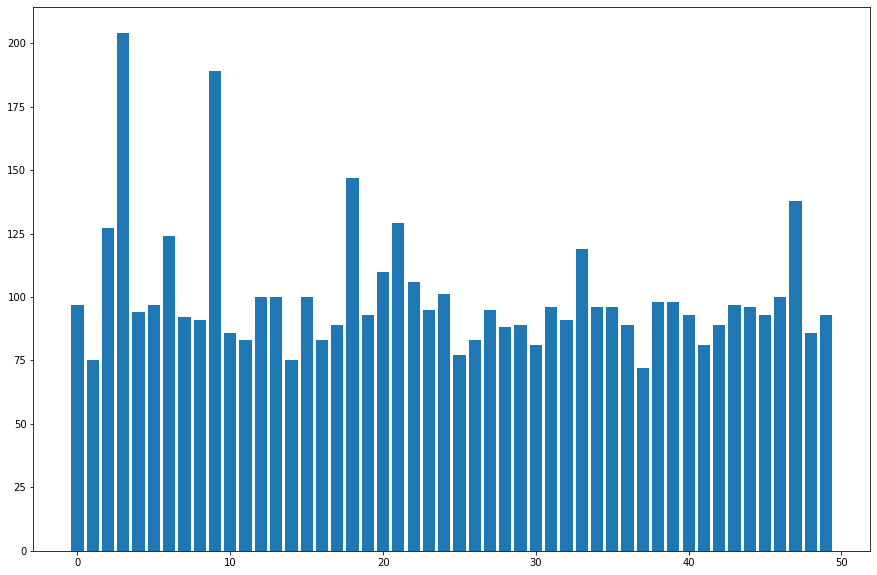

In [11]:
classes_dict = {k:v for k,v in zip(classes, range(len(classes)))}
@tf.function
def count_class(counts, batch):
    y, _, c = tf.unique_with_counts(batch[1])
    return tf.tensor_scatter_nd_add(counts, tf.expand_dims(y, axis=1), c)

counts = train_data.reduce(
    initial_state=tf.zeros(len(classes), tf.int32),
    reduce_func=count_class)

plt.figure(figsize=(15, 10))
plt.bar(range(len(classes)), counts.numpy())
plt.show()

## Defining callbacks for training

- We define some callbacks for model training. 
- `tf.keras.callbacks.ReduceLROnPlateau` is used to track a metric and upon its stagnation, penalize the learning rate by a predetermined multiplier to get a finer gradient push
- `tf.keras.callbacks.EarlyStopping` is not used as it was breaking the training loop pre-maturely due to its design

In [12]:
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='accuracy',
        factor=0.1,
        min_lr=0.000001,
        patience=2,
        verbose=1
    )
]

In [13]:
nas_callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.1,
        min_lr=0.000001,
        patience=2,
        verbose=1
    )
]

## Defining Model metric display functions

- Defining a function to display plots/charts of all parameters present in Model history after training

In [14]:
def plotHistoryMetrics(history:keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots//2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1,total_plots+1)
    plt.figure(figsize=(15,10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

# Modelling

## 1. **Custom ResNet-style Model**

We take this model as a simple trial to understand what kind of models will work well with the dataset. It has 1 specific block of 2 `Conv2D` layers, 1 `LayerNorm` and 1 `GaussianDropout` along with skip connections between each such block.

### Defining custom model in a ResNet-fashion

In [ ]:
cnn_input = keras.Input(shape=(None, None, 3), name='cnn_input')

img_x = keras.layers.Resizing(224, 224, interpolation='bilinear', name='resizing')(cnn_input)

img_x1 = keras.layers.Conv2D(filters=64, kernel_size=1, strides=2, activation='relu', padding='same', name='block1_conv1', kernel_regularizer=keras.regularizers.L2(), kernel_initializer=keras.initializers.he_uniform())(img_x)
img_x1 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', padding='same', name='block1_conv2', kernel_regularizer=keras.regularizers.L2(), kernel_initializer=keras.initializers.he_uniform())(img_x1)
img_x1 = keras.layers.LayerNormalization(name='block1_layernorm')(img_x1)
img_x1 = keras.layers.GaussianDropout(rate=0.2, name='block1_gausdropout')(img_x1)

img_x_conv = keras.layers.Conv2D(filters=128, kernel_size=1, strides=4, name='block1_input_conv', kernel_regularizer=keras.regularizers.L2(), kernel_initializer=keras.initializers.he_uniform())(img_x)
img_x1 = keras.layers.Add()([img_x_conv, img_x1])
img_x1 = keras.layers.ReLU()(img_x1)

img_x2 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, activation='relu', padding='same', name='block2_conv1', kernel_regularizer=keras.regularizers.L2(), kernel_initializer=keras.initializers.he_uniform())(img_x1)
img_x2 = keras.layers.Conv2D(filters=512, kernel_size=1, strides=2, activation='relu', name='block2_conv2', kernel_regularizer=keras.regularizers.L2(), kernel_initializer=keras.initializers.he_uniform())(img_x2)
img_x2 = keras.layers.LayerNormalization(name='block2_layernorm')(img_x2)
img_x2 = keras.layers.GaussianDropout(rate=0.2, name='block2_gausdropout')(img_x2)

img_x1_conv = keras.layers.Conv2D(filters=512, kernel_size=1, strides=4, name='block2_input_conv', kernel_regularizer=keras.regularizers.L2(), kernel_initializer=keras.initializers.he_uniform())(img_x1)
img_x2 = keras.layers.Add()([img_x1_conv, img_x2])
img_x2 = keras.layers.ReLU()(img_x2)

img_x3 = keras.layers.Conv2D(filters=2048, kernel_size=1, strides=2, activation='relu', padding='same', name='block3_conv2', kernel_regularizer=keras.regularizers.L2(), kernel_initializer=keras.initializers.he_uniform())(img_x2)
img_x3 = keras.layers.LayerNormalization(name='block3_layernorm')(img_x3)
img_x3 = keras.layers.GaussianDropout(rate=0.2, name='block3_gausdropout')(img_x3)

img_x2_conv = keras.layers.Conv2D(filters=2048, kernel_size=1, strides=2, name='block3_input_conv', kernel_regularizer=keras.regularizers.L2(), kernel_initializer=keras.initializers.he_uniform())(img_x2)
img_x3 = keras.layers.Add()([img_x2_conv, img_x3])
img_x3 = keras.layers.ReLU()(img_x3)

img_output = keras.layers.MaxPool2D(pool_size=3)(img_x3)


x = keras.layers.GlobalAveragePooling2D()(img_output)
x = keras.layers.Dense(1024, activation='relu', name='dense1', kernel_regularizer=keras.regularizers.L2(), kernel_initializer=keras.initializers.he_uniform())(x)
x = keras.layers.Dense(128, activation='relu', name='dense2', kernel_regularizer=keras.regularizers.L2(), kernel_initializer=keras.initializers.he_uniform())(x)
output = keras.layers.Dense(len(classes), activation='softmax', name='output_layer', kernel_regularizer=keras.regularizers.L2(), kernel_initializer=keras.initializers.he_uniform())(x)


custom_model = keras.Model(inputs=cnn_input, outputs=output)
custom_model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy', 'mean_squared_error']
)
custom_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cnn_input (InputLayer)         [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['cnn_input[0][0]']              
                                                                                                  
 block1_conv1 (Conv2D)          (None, 112, 112, 64  256         ['resizing[0][0]']               
                                )                                                                 
                                                                                              

### Model training loop and saving model to Google Drive for further use

In [ ]:
custom_history = custom_model.fit(train_ds, epochs=3, validation_data=valid_ds, callbacks=callbacks_list)
saveModel(custom_model, 'custom')

Epoch 1/3
157/157 [==============================] - 33s 109ms/step - loss: 43.0368 - accuracy: 0.0299 - mean_squared_error: 772.6225 - val_loss: 7.5401 - val_accuracy: 0.0628 - val_mean_squared_error: 772.8342 - lr: 0.0010
Epoch 2/3
157/157 [==============================] - 15s 95ms/step - loss: 6.3679 - accuracy: 0.0386 - mean_squared_error: 772.6218 - val_loss: 5.7523 - val_accuracy: 0.0628 - val_mean_squared_error: 772.8342 - lr: 0.0010
Epoch 3/3
157/157 [==============================] - 15s 98ms/step - loss: 5.4135 - accuracy: 0.0398 - mean_squared_error: 772.6218 - val_loss: 5.0633 - val_accuracy: 0.0628 - val_mean_squared_error: 772.8342 - lr: 0.0010


### Displaying plots from `History` of model training

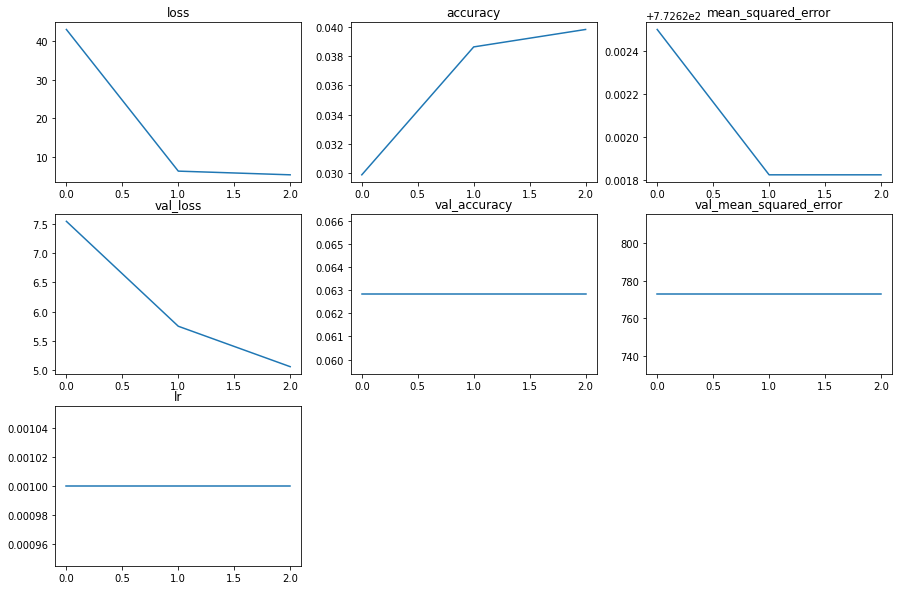

In [ ]:
plotHistoryMetrics(custom_history)

## 2. **VGG-19 Model**

We take this deep network to understand what kind of results a fairly deep Convolutional neural networks will return. It has a total of 19 layers. It was developed by the Visual Geometry Group at Oxford University. More about the model can be [discovered here](https://keras.io/api/applications/vgg/)

![](https://www.researchgate.net/profile/Clifford-Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg)

### Defining skeleton VGG-19 model from Keras for training 

- We do not use Image-net weights as they did not return suitable results
- We train the model from scratch, which takes considerable resources but does not end up yielding good results
- We use `tf.keras.regularizers.L2()` to make sure that there is a regularizing effect on all the Dense layers in the network, as well as a `Dropout` layer for extra regularization effect.
- We initialize the weights using `tf.keras.initializers.HeUniform()` for better convergibility (did not end up working too well)

In [ ]:
vgg_input = keras.Input(shape=(224, 224, 3))
x = keras.applications.vgg19.preprocess_input(vgg_input)
vgg = keras.applications.VGG19(
        include_top=False,
        weights=None
)
x = vgg(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L2(), kernel_initializer=keras.initializers.he_uniform())(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L2(), kernel_initializer=keras.initializers.he_uniform())(x)
vgg_output = keras.layers.Dense(len(classes), activation='softmax', kernel_regularizer=keras.regularizers.L2(), kernel_initializer=keras.initializers.he_uniform())(x)


vgg_model = keras.Model(inputs=vgg_input, outputs=vgg_output)
vgg_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, amsgrad=True),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', 'mean_squared_error']
)
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 128)               6566

### Model training loop and saving model to Google Drive for further use

In [ ]:
vgg_history = vgg_model.fit(train_ds, epochs=3, validation_data=valid_ds, callbacks=callbacks_list)
saveModel(vgg_model, 'vgg')

Epoch 1/3
157/157 [==============================] - 92s 536ms/step - loss: 30.5543 - accuracy: 0.0321 - mean_squared_error: 772.6219 - val_loss: 5.7252 - val_accuracy: 0.0628 - val_mean_squared_error: 772.8342 - lr: 0.0010
Epoch 2/3
157/157 [==============================] - 77s 491ms/step - loss: 5.5485 - accuracy: 0.0386 - mean_squared_error: 772.6218 - val_loss: 5.4316 - val_accuracy: 0.0323 - val_mean_squared_error: 772.8342 - lr: 0.0010
Epoch 3/3
157/157 [==============================] - 78s 496ms/step - loss: 5.3922 - accuracy: 0.0404 - mean_squared_error: 772.6218 - val_loss: 5.3516 - val_accuracy: 0.0628 - val_mean_squared_error: 772.8342 - lr: 0.0010


### Displaying plots from `History` of model training

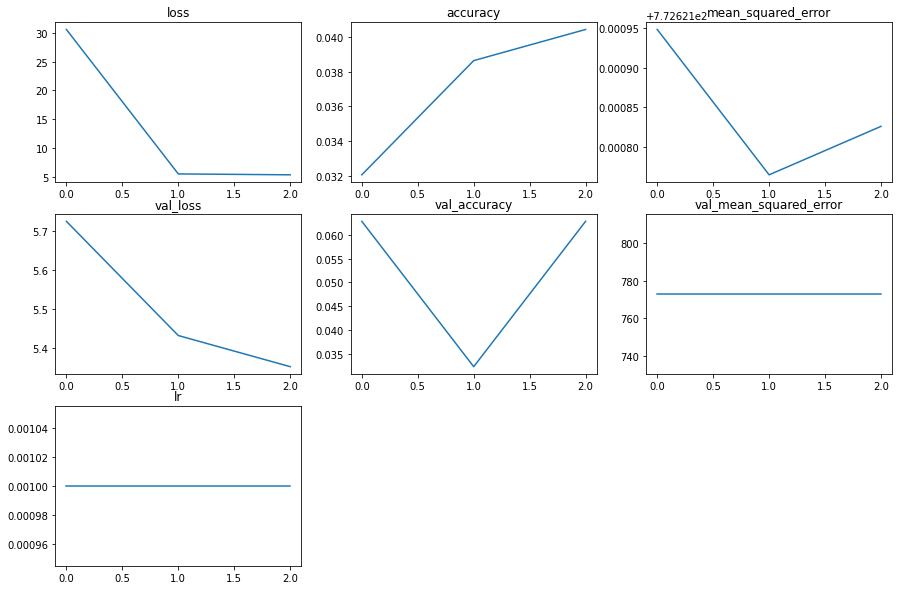

In [ ]:
plotHistoryMetrics(vgg_history)

## 3. **Inception-ResNet-V2 Model**

We take this deep network to understand what kind of results an extremely deep class of Convolutional neural networks will return. It is based on the Inception class of models that were introduced by Facebook, but incorporates the Residual connection logic introduced by Microsoft. It showed wonderful results on the ILSVRC challenge. More about the model can be [discovered here](https://keras.io/api/applications/inceptionresnetv2/)

![](https://www.researchgate.net/publication/327425789/figure/fig3/AS:667190047027201@1536081911884/A-modified-version-of-Inception-ResNet-V2-Szegedy-et-al-2016-was-used-as-the.ppm)

### Defining pre-trained Inception-ResNet-v2 model from Keras for training 

- We do use Image-net weights as the classifier performed considerably better with those weights, although not with satisfactory results
- We use `tf.keras.regularizers.L2()` to make sure that there is a regularizing effect on all the Dense layers in the network, as well as a `Dropout` layer for extra regularization effect.
- We initialize the weights using `tf.keras.initializers.GlorotUniform()` as is the standard
- We freeze the `BatchNorm` layers as per a recommendation by the Keras authors

In [ ]:
inception_input = keras.Input(shape=(224, 224, 3))
x = keras.applications.inception_resnet_v2.preprocess_input(inception_input)
inception = keras.applications.InceptionResNetV2(
        include_top=False,
        weights='imagenet'
)
for l in inception.layers:
    if l.name[0:19] == "batch_normalization":
        l.trainable = False

x = inception(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L2())(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L2())(x)
inception_output = keras.layers.Dense(len(classes), activation='softmax', kernel_regularizer=keras.regularizers.L2())(x)


inception_model = keras.Model(inputs=inception_input, outputs=inception_output)
inception_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, amsgrad=True),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', 'mean_squared_error']
)
inception_model.summary()

219070464/219055592 [==============================] - 3s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 global_average_pooling2d_2   (None, 1536)             0  

### Model training loop and saving model to Google Drive for further use

In [ ]:
inception_history = inception_model.fit(train_ds, epochs=3, validation_data=valid_ds, callbacks=callbacks_list)
saveModel(inception_model, 'inception-v2')

Epoch 1/3
157/157 [==============================] - 117s 630ms/step - loss: 4.9948 - accuracy: 0.0335 - mean_squared_error: 772.6218 - val_loss: 4.1836 - val_accuracy: 0.0628 - val_mean_squared_error: 772.8342 - lr: 0.0010
Epoch 2/3
157/157 [==============================] - 90s 576ms/step - loss: 4.0641 - accuracy: 0.0410 - mean_squared_error: 772.6218 - val_loss: 3.9833 - val_accuracy: 0.0628 - val_mean_squared_error: 772.8342 - lr: 0.0010
Epoch 3/3
157/157 [==============================] - 90s 570ms/step - loss: 3.9535 - accuracy: 0.0406 - mean_squared_error: 772.6218 - val_loss: 3.9236 - val_accuracy: 0.0628 - val_mean_squared_error: 772.8342 - lr: 0.0010


### Displaying plots from `History` of model training

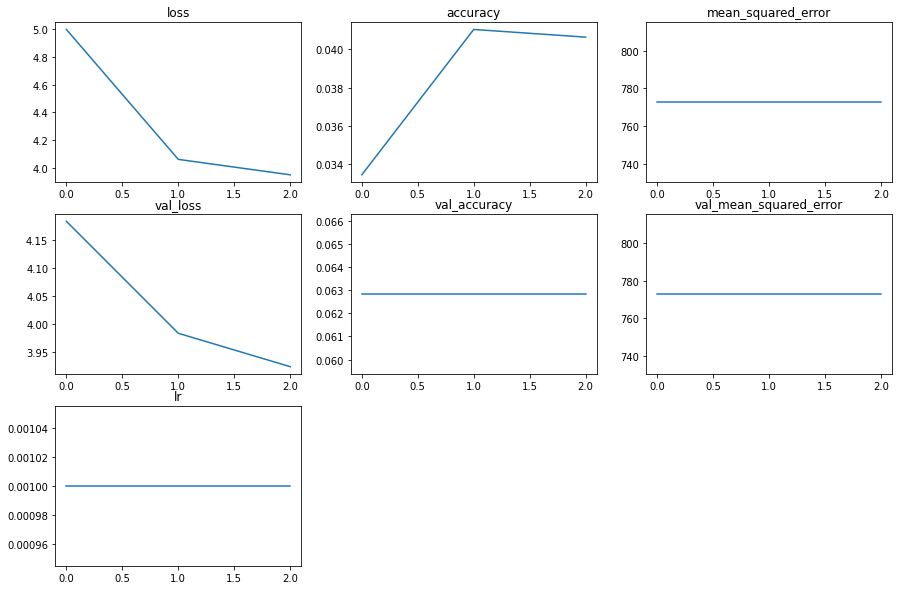

In [ ]:
plotHistoryMetrics(inception_history)

## 4. **EfficientNet-B2 Model**

We take this network as it has been reportedly been a high-performing model with medium inference cost at its parameter-count class. The B2 version of the model is the closest model present to the input shape (260, 260, 3) while lower versions like B0 and B1 can give good results too. For the purposes of this notebook, we only explore B2. 
More about the model can be [discovered here](https://keras.io/api/applications/efficientnet/#efficientnetb2-function)

![](https://1.bp.blogspot.com/-DjZT_TLYZok/XO3BYqpxCJI/AAAAAAAAEKM/BvV53klXaTUuQHCkOXZZGywRMdU9v9T_wCLcBGAs/s1600/image2.png)

### Note:

This model requires a specific size of input shape, different from other models. Henc,e we make changes to the image dataset here and pre-process them from scratch

#### Data-loading and Pre-processing

In [15]:
train_eff_data = keras.utils.image_dataset_from_directory(
    'BarkVN-50',
    labels='inferred',
    label_mode='int',
    image_size=(260, 260),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=0.15,
    subset='training'
)

valid_eff_data = keras.utils.image_dataset_from_directory(
    'BarkVN-50',
    labels='inferred',
    label_mode='int',
    image_size=(260, 260),
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED,
    validation_split=0.15,
    subset='validation'
)

def format_image_effb2(image, label):

    image = tf.cast(image, tf.float32)
    return image, label

def prepare_ds_effb2(ds):
    
    ds = ds.map(format_image_effb2)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    ds = ds.cache()
    return ds

train_eff_ds = prepare_ds_effb2(train_eff_data)
valid_eff_ds = prepare_ds_effb2(valid_eff_data)

Found 5578 files belonging to 50 classes.
Using 4742 files for training.
Found 5578 files belonging to 50 classes.
Using 836 files for validation.


### Defining skeleton EfficientNetB2 model from Keras for training 

- We do not use Image-net weights as the classifier did not perform well enough with it. A considerable improvement was seen while training from scratch, albeit with requirement for more resources
- We use `tf.keras.regularizers.L2()` to make sure that there is a regularizing effect on all the Dense layers in the network, as well as a `Dropout` layer for extra regularization effect.
- We initialize the weights using `tf.keras.initializers.GlorotUniform()` as is the standard
- The `tf.keras.layers.Dense` layer used has 128 connections, instead of the standard 512 used in other models above and below

In [16]:
effnet_input = keras.Input(shape=(260, 260, 3))
x = effnet_input
effnet = keras.applications.EfficientNetB2(
        include_top=False,
        weights=None,
)

x = effnet(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L2())(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L2())(x)
effnet_output = keras.layers.Dense(len(classes), activation='softmax', kernel_regularizer=keras.regularizers.L2())(x)


effnet_model = keras.Model(inputs=effnet_input, outputs=effnet_output)
effnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, amsgrad=True),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', 'mean_squared_error']
)
effnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 260, 260, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 flatten (Flatten)           (None, 90112)             0         
                                                                 
 dense (Dense)               (None, 128)               11534464  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 50)                3250  

### Model training loop and saving model to Google Drive for further use

In [19]:
effnet_history = effnet_model.fit(train_eff_ds, epochs=20, validation_data=valid_eff_ds, callbacks=callbacks_list)
saveModel(effnet_model, 'effnet')

Epoch 1/20
149/149 [==============================] - 94s 628ms/step - loss: 0.9706 - accuracy: 0.8669 - mean_squared_error: 766.4363 - val_loss: 2.4678 - val_accuracy: 0.5371 - val_mean_squared_error: 807.9436 - lr: 0.0010
Epoch 2/20
149/149 [==============================] - 94s 628ms/step - loss: 0.9046 - accuracy: 0.8823 - mean_squared_error: 766.4365 - val_loss: 2.7368 - val_accuracy: 0.5347 - val_mean_squared_error: 807.9439 - lr: 0.0010
Epoch 3/20
149/149 [==============================] - 93s 625ms/step - loss: 0.9114 - accuracy: 0.8781 - mean_squared_error: 766.4369 - val_loss: 2.6670 - val_accuracy: 0.5347 - val_mean_squared_error: 807.9442 - lr: 0.0010
Epoch 4/20
149/149 [==============================] - ETA: 0s - loss: 0.9007 - accuracy: 0.8785 - mean_squared_error: 766.4370
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
149/149 [==============================] - 93s 628ms/step - loss: 0.9007 - accuracy: 0.8785 - mean_squared_error: 766.4370 -

### Displaying plots from `History` of model training

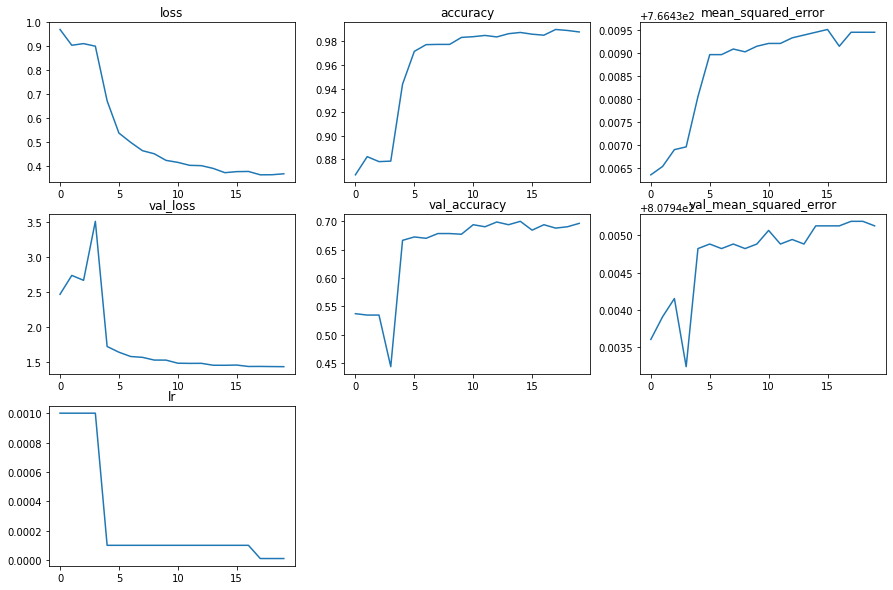

In [21]:
plotHistoryMetrics(effnet_history)

### Re-training of old/saved models for more epochs

- Trained the model for 50 epochs as it resulted in an accuracy of upto 84% on validation, in its current configuration. That is the highest validation accuracy achieved until now in the complete notebook

In [ ]:
loaded_effnet_model = loadModel('effnet3')
print(loaded_effnet_model.summary())
print(loaded_effnet_model.metrics_names)
loaded_effnet_model.evaluate(valid_ds)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 average_pooling2d_1 (Averag  (None, 3, 3, 1408)       0         
 ePooling2D)                                                     
                                                                 
 flatten_4 (Flatten)         (None, 12672)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               1622144   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                           

[1.0015037059783936, 0.8294434547424316, 772.849853515625]

## 5. **ResNet-50 Model**

The ResNet architecture is considered to be among the most popular Convolutional Neural Network architectures around. Introduced by Microsoft Research in 2015, Residual Networks (ResNet in short) broke several records when it was first introduced in a paper by He et.al.
More about the model can be [discovered here](https://keras.io/api/applications/resnet/#resnet50-function).   
I have also previously written a blog on this model, detailing its architecture and intricacies. [Find it here](https://medium.com/p/a6c536034758)

![](https://suvadityamuk.github.io/portfolio/images/images/resnet50/resnet50.png)

### Defining pre-trained ResNet-50 model from Keras for training 

- We do use Image-net weights as the classifier took too long to train without freezing the ResNet layers. 
- We use `tf.keras.regularizers.L2()` to make sure that there is a regularizing effect on all the Dense layers in the network, as well as a `Dropout` layer for extra regularization effect.
- We initialize the weights using `tf.keras.initializers.GlorotUniform()` as is the standard
- The `tf.keras.layers.Dense` layer used has 128 connections, instead of the standard 512 used in other models above and below

In [ ]:
resnet_input = keras.Input(shape=(224, 224, 3))
x = keras.applications.resnet50.preprocess_input(resnet_input)
resnet = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet'
)
resnet.trainable = False
x = resnet(x)
x = keras.layers.MaxPool2D(pool_size=4)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L2())(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L2())(x)
resnet_output = keras.layers.Dense(len(classes), activation='softmax', kernel_regularizer=keras.regularizers.L2())(x)


resnet_model = keras.Model(inputs=resnet_input, outputs=resnet_output)
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, amsgrad=True),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', 'mean_squared_error']
)
resnet_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 1, 1, 2048)       0         
 2D)                                                             
                                                           

### Model training loop and saving model to Google Drive for further use

In [ ]:
resnet_history = resnet_model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks=callbacks_list)
saveModel(resnet_model, 'resnet')

Epoch 1/20
157/157 [==============================] - 17s 106ms/step - loss: 3.1948 - accuracy: 0.1890 - mean_squared_error: 772.6231 - val_loss: 3.1133 - val_accuracy: 0.2208 - val_mean_squared_error: 772.8353 - lr: 1.0000e-05
Epoch 2/20
157/157 [==============================] - 17s 108ms/step - loss: 3.2013 - accuracy: 0.1932 - mean_squared_error: 772.6232 - val_loss: 3.1130 - val_accuracy: 0.2172 - val_mean_squared_error: 772.8353 - lr: 1.0000e-05
Epoch 3/20
157/157 [==============================] - 17s 108ms/step - loss: 3.1921 - accuracy: 0.1946 - mean_squared_error: 772.6231 - val_loss: 3.1123 - val_accuracy: 0.2190 - val_mean_squared_error: 772.8353 - lr: 1.0000e-05
Epoch 4/20
157/157 [==============================] - 17s 107ms/step - loss: 3.1940 - accuracy: 0.1904 - mean_squared_error: 772.6231 - val_loss: 3.1124 - val_accuracy: 0.2172 - val_mean_squared_error: 772.8353 - lr: 1.0000e-05
Epoch 5/20
157/157 [==============================] - ETA: 0s - loss: 3.1946 - accuracy:

### Displaying plots from `History` of model training

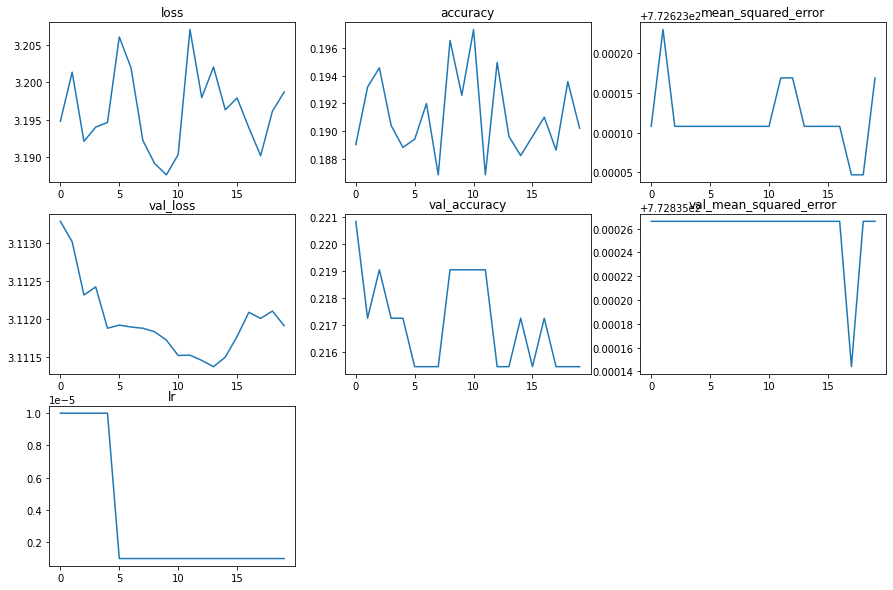

In [ ]:
plotHistoryMetrics(resnet_history)

## 6. **NeuralArchitectureSearch-Mobile Model**

The NeuralArchitectureSearch is a method to learn the model architectures directly on the dataset of interest. The most important fact is that there is a new search space defined for finding the perfect model.
More about the model can be [discovered here](https://keras.io/api/applications/nasnet/#nasnetmobile-function).   

![](https://www.researchgate.net/profile/Ssvr-Addagarla/publication/344252628/figure/fig2/AS:936050247614466@1600183178512/Resent-Architecture-C-NASNetMobile-Neural-Architecture-Search-Network-Nasnet-was.jpg)

### Defining skeleton NASNetMobile model from Keras for training 

- We do not use Image-net weights as the essence of this model is the fact that it will learn based on the dataset presented to it.
- We use `tf.keras.regularizers.L2()` to make sure that there is a regularizing effect on all the Dense layers in the network, as well as a `Dropout` layer for extra regularization effect.
- We initialize the weights using `tf.keras.initializers.GlorotUniform()` as is the standard
- We perform a MaxPooling2D operation before Flatten to reduce number of parameters
- The `tf.keras.layers.Dense` layer used has 128 connections, instead of the standard 512 used in other models above and below

In [ ]:
nasnet_mob_input = keras.Input(shape=(224, 224, 3))
x = keras.applications.nasnet.preprocess_input(nasnet_mob_input)
nasnet_mob = keras.applications.nasnet.NASNetMobile(
        include_top=False,
        weights=None
)

x = nasnet_mob(x)
x = keras.layers.MaxPooling2D(pool_size=4)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L2())(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L2())(x)
nasnet_mob_output = keras.layers.Dense(len(classes), activation='softmax', kernel_regularizer=keras.regularizers.L2())(x)

nasnet_mob_model = keras.Model(inputs=nasnet_mob_input, outputs=nasnet_mob_output)
nasnet_mob_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', 'mean_squared_error']
)
nasnet_mob_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 1, 1, 1056)       0         
 2D)                                                             
                                                           

In [ ]:
nas_history = nasnet_mob_model.fit(train_ds, epochs=3, validation_data=valid_ds, callbacks=nas_callbacks_list)
saveModel(nasnet_mob_model, 'nasnet-25sept-2')

Epoch 1/3
157/157 [==============================] - 87s 404ms/step - loss: 5.7198 - accuracy: 0.1340 - mean_squared_error: 772.6231 - val_loss: 6.2292 - val_accuracy: 0.0628 - val_mean_squared_error: 772.8354 - lr: 0.0010
Epoch 2/3
157/157 [==============================] - 59s 377ms/step - loss: 3.5649 - accuracy: 0.2954 - mean_squared_error: 772.6251 - val_loss: 5.6890 - val_accuracy: 0.0126 - val_mean_squared_error: 772.8354 - lr: 0.0010
Epoch 3/3
157/157 [==============================] - ETA: 0s - loss: 2.7118 - accuracy: 0.4037 - mean_squared_error: 772.6266
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
157/157 [==============================] - 59s 376ms/step - loss: 2.7118 - accuracy: 0.4037 - mean_squared_error: 772.6266 - val_loss: 7.4226 - val_accuracy: 0.0215 - val_mean_squared_error: 772.8423 - lr: 0.0010


### Displaying plots from `History` of model training

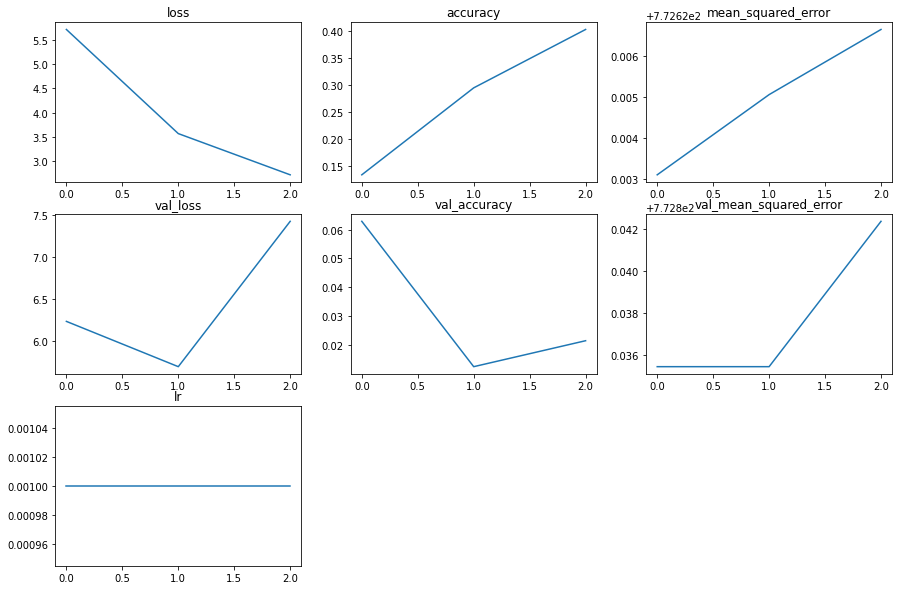

In [ ]:
plotHistoryMetrics(nas_history)

## 7. **XCeption Model**

The XCeption model stands for Extreme version of Inception. With a modified depthwise separable convolution, it is even better than Inception-v3 on the ILSVRC and JFT datasets.
More about the model can be [discovered here](https://keras.io/api/applications/xception).   

![](https://www.researchgate.net/profile/Erik-Westphal/publication/350319854/figure/fig3/AS:1007308788203524@1617172538729/Xception-CNN-architecture-for-the-detection-and-classification-of-powder-bed-defects-at.png)

### Defining pre-trained XCeption model from Keras for training 

- We do use Image-net weights as the classifier took too long to train without freezing the pre-trained layers. 
- We use `tf.keras.regularizers.L2()` to make sure that there is a regularizing effect on all the Dense layers in the network, as well as a `Dropout` layer for extra regularization effect.
- We initialize the weights using `tf.keras.initializers.GlorotUniform()` as is the standard
- The `Dropout` layer is also removed as a design choice

In [ ]:
xception_input = keras.Input(shape=(224, 224, 3))
x = keras.applications.xception.preprocess_input(xception_input)

xception = keras.applications.xception.Xception(
        include_top=False,
        weights='imagenet'
)
xception.trainable = False
x = xception(x)
x = keras.layers.MaxPooling2D(pool_size=4)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L2())(x)
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L2())(x)
xception_output = keras.layers.Dense(len(classes), activation='softmax', kernel_regularizer=keras.regularizers.L2())(x)


xception_model = keras.Model(inputs=xception_input, outputs=xception_output)
xception_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, amsgrad=True),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', 'mean_squared_error']
)
xception_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 1, 2048)       0         
 2D)                                                        

### Model training loop and saving model to Google Drive for further use

In [ ]:
xception_history = xception_model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks=callbacks_list)
saveModel(xception_model, 'xception-imgnet')

Epoch 1/20
157/157 [==============================] - 23s 145ms/step - loss: 3.6120 - accuracy: 0.0896 - mean_squared_error: 772.6223 - val_loss: 3.5831 - val_accuracy: 0.1221 - val_mean_squared_error: 772.8346 - lr: 0.0010
Epoch 2/20
157/157 [==============================] - 23s 145ms/step - loss: 3.5934 - accuracy: 0.0898 - mean_squared_error: 772.6224 - val_loss: 3.5698 - val_accuracy: 0.1221 - val_mean_squared_error: 772.8346 - lr: 0.0010
Epoch 3/20
157/157 [==============================] - 24s 150ms/step - loss: 3.5839 - accuracy: 0.0920 - mean_squared_error: 772.6224 - val_loss: 3.5622 - val_accuracy: 0.1203 - val_mean_squared_error: 772.8346 - lr: 0.0010
Epoch 4/20
157/157 [==============================] - 22s 143ms/step - loss: 3.5780 - accuracy: 0.0928 - mean_squared_error: 772.6224 - val_loss: 3.5581 - val_accuracy: 0.1203 - val_mean_squared_error: 772.8346 - lr: 0.0010
Epoch 5/20
157/157 [==============================] - 23s 149ms/step - loss: 3.5739 - accuracy: 0.0924 -

### Displaying plots from `History` of model training

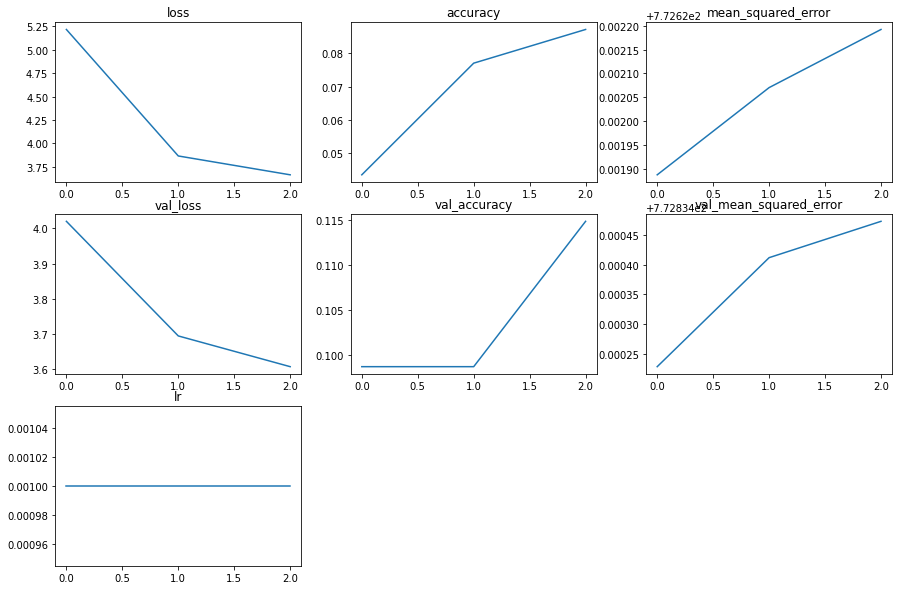

In [ ]:
plotHistoryMetrics(xception_history)

## 8. **ViT Model**

Transformers initially introduced in 2017 in the well-known paper "Attention is All You Need"have spread widely in the field of Natural Language Processing soon becoming one of the most widely used and promising architectures in the field.

In 2020 Vision Transformers were then adapted for tasks in Computer Vision with the paper "An image is worth 16x16 words".The idea is basically to break down input images as a series of patches which, once transformed into vectors, are seen as words in a normal transformer.

The ViT model used here is taken from a third-party package. 
More about the model can be [discovered here](https://keras.io/api/applications/xception).   

![](https://viso.ai/wp-content/uploads/2021/09/vision-transformer-vit.png)





### Defining skeleton ViT model from Keras for training 

- We do not use Image-net weights as the model did not perform well enough with the use of these weights.
- We use `tf.keras.regularizers.L2()` to make sure that there is a regularizing effect on all the Dense layers in the network, as well as a `Dropout` layer for extra regularization effect.
- We initialize the weights using `tf.keras.initializers.GlorotUniform()` as is the standard

In [ ]:
!pip install vit-keras tensorflow-addons
from vit_keras import vit, utils

image_size = 224

vit_input = keras.Input(shape=(224, 224, 3))

x = vit.preprocess_inputs(vit_input)
vit = vit.vit_b16(
    image_size=image_size,
    pretrained=False,
    include_top=False,
    pretrained_top=False,
)
x = vit(x)
x = keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L2())(x)
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L2())(x)
vit_output = keras.layers.Dense(len(classes), activation='softmax', kernel_regularizer=keras.regularizers.L2())(x)


vit_model = keras.Model(inputs=vit_input, outputs=vit_output)
vit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01, amsgrad=True),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', 'mean_squared_error']
)
vit_model.summary()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.6 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=b89b35af0d3a81d381b2887fb5fda2673e70052b6f2f0dc2b1d371211cd40cd7
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 224, 224, 3)      0         
 bd

### Model training loop and saving model to Google Drive for further use

In [ ]:
vit_history = vit_model.fit(train_ds, epochs=3, validation_data=valid_ds, callbacks=callbacks_list)
saveModel(vit_model, 'vit')

Epoch 1/3
157/157 [==============================] - 230s 1s/step - loss: 5.4443 - accuracy: 0.0384 - mean_squared_error: 772.6219 - val_loss: 3.9396 - val_accuracy: 0.0628 - val_mean_squared_error: 772.8342 - lr: 0.0100
Epoch 2/3
157/157 [==============================] - 199s 1s/step - loss: 3.9149 - accuracy: 0.0406 - mean_squared_error: 772.6218 - val_loss: 3.8818 - val_accuracy: 0.0628 - val_mean_squared_error: 772.8342 - lr: 0.0100
Epoch 3/3
157/157 [==============================] - 203s 1s/step - loss: 3.8944 - accuracy: 0.0406 - mean_squared_error: 772.6218 - val_loss: 3.8763 - val_accuracy: 0.0628 - val_mean_squared_error: 772.8343 - lr: 0.0100


### Displaying plots from `History` of model training

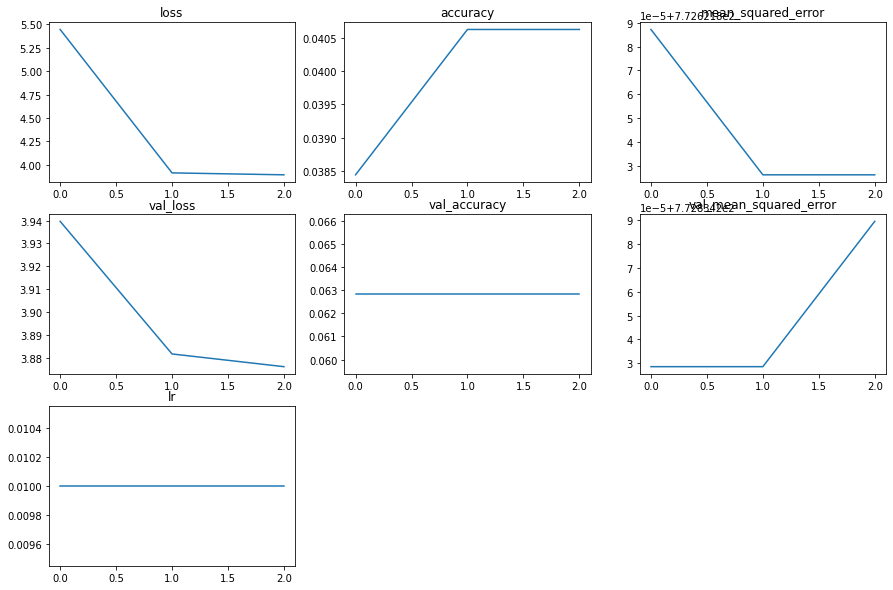

In [ ]:
plotHistoryMetrics(vit_history)

# Visualize predicted samples

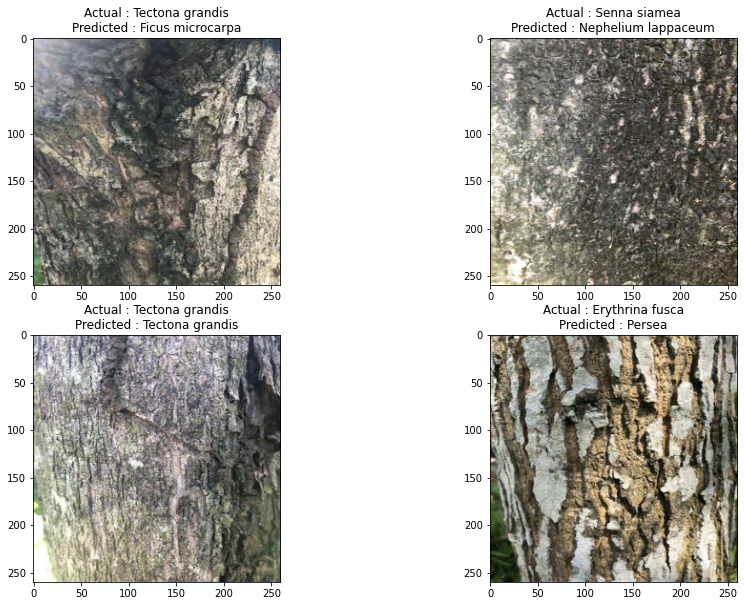

In [27]:
def visualizePredictedSamples(data:tf.data.Dataset, model:keras.Model, num_samples:int=BATCH_SIZE):

    total_plots = num_samples

    cols = num_samples//2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1
    
    pos = range(1,total_plots+1)
    plt.figure(figsize=(15,10))
    for i, (images,labels) in enumerate(data.take((num_samples//BATCH_SIZE)+1)):
        for i in range(total_plots):
            image = images[i]
            image_tensor = tf.expand_dims(image, 0)
            pred = tf.argmax(model.predict(image_tensor), axis=1)
            plt.subplot(rows, cols, pos[i])
            plt.imshow(image.numpy().astype('uint8'))
            plt.title(f'Actual : {classes[labels[i]]}\nPredicted : {classes[int(pred.numpy())]}')
    plt.show()

visualizePredictedSamples(valid_eff_ds, effnet_model, 4)